# DAG Workflow Execution

Execute multi-step workflows with dependencies using the DAG (Directed Acyclic Graph) executor.

**Features:**

- Parallel execution of independent tasks
- Dependency management between tasks
- State management and checkpoints
- Event streaming for real-time progress

## Setup

In [1]:
import {
  createInitialState,
  type DAGExecutionResult,
  DenoSandboxExecutor,
  ParallelExecutor,
  type ToolExecutor,
} from "jsr:@casys/mcp-gateway";

// Create sandbox for code execution
const sandbox = new DenoSandboxExecutor({
  timeout: 5000,
  memoryLimit: 128,
});

console.log("✅ DAG executor ready");

✅ DAG executor ready


In [2]:
// Import visualization helpers
import { dagStats, dagToMermaid, displayDag, displayLayers, layersToMermaid } from "../lib/viz.ts";

console.log("📊 Visualization helpers loaded (with display functions)");

📊 Visualization helpers loaded (with display functions)


## Define a Simple DAG

Create a workflow with 3 tasks:

```
fetchData → processData → aggregate
```

DAG Stats:
  - Total tasks: 3
  - Entry points: 1
  - With dependencies: 2
  - Workflow ID: simple-dag


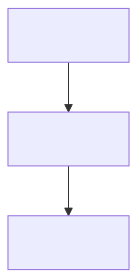

In [3]:
// Convert DAG to proper format
const dagWorkflow = {
  id: "simple-dag",
  tasks: [
    { id: "fetchData", tool_name: "sandbox", dependencies: [] },
    { id: "processData", tool_name: "sandbox", dependencies: ["fetchData"] },
    { id: "aggregate", tool_name: "sandbox", dependencies: ["processData"] },
  ],
};

console.log(dagStats(dagWorkflow));

// Display visual diagram
await displayDag(dagWorkflow);

## Visualize DAG Structure

View the DAG as a Mermaid diagram:

In [4]:
const dag = {
  tasks: {
    fetchData: {
      tool: "sandbox",
      params: { code: "return { numbers: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] }" },
      dependencies: [],
    },
    processData: {
      tool: "sandbox",
      params: { code: "return context.numbers.map(n => n * n)" },
      dependencies: ["fetchData"],
    },
    aggregate: {
      tool: "sandbox",
      params: { code: "return { sum: context.reduce((a, b) => a + b, 0), count: context.length }" },
      dependencies: ["processData"],
    },
  },
};

console.log("📊 DAG defined:");
console.log("   Tasks:", Object.keys(dag.tasks).join(" → "));

📊 DAG defined:
   Tasks: fetchData → processData → aggregate


## Execute DAG Manually

Step through each task to see how it works:

💡 Layer 0 executes in parallel, Layer 1 waits for both



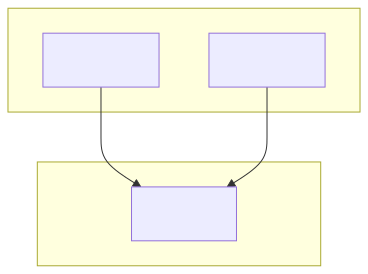

In [5]:
const parallelDagWorkflow = {
  id: "parallel-dag",
  tasks: [
    { id: "taskA", tool_name: "random", dependencies: [] },
    { id: "taskB", tool_name: "random", dependencies: [] },
    { id: "combine", tool_name: "merge", dependencies: ["taskA", "taskB"] },
  ],
};

// Show as layers (parallel execution groups)
const layers = [
  [parallelDagWorkflow.tasks[0], parallelDagWorkflow.tasks[1]], // Layer 0: parallel
  [parallelDagWorkflow.tasks[2]], // Layer 1: fan-in
];

console.log("💡 Layer 0 executes in parallel, Layer 1 waits for both\n");

// Display visual diagram
await displayLayers(layers);

## Visualize Parallel Execution

See parallel tasks and fan-in pattern:

In [6]:
// Execute fetchData
console.log("\n📥 Step 1: fetchData");
const result1 = await sandbox.execute(dag.tasks.fetchData.params.code);
console.log("   Result:", result1.result);

// Execute processData with context from fetchData
console.log("\n⚙️  Step 2: processData");
const result2 = await sandbox.execute(
  dag.tasks.processData.params.code,
  result1.result, // Pass previous result as context
);
console.log("   Result:", result2.result);

// Execute aggregate with context from processData
console.log("\n📊 Step 3: aggregate");
const result3 = await sandbox.execute(
  dag.tasks.aggregate.params.code,
  result2.result,
);
console.log("   Result:", result3.result);

console.log("\n✅ Workflow complete!");


📥 Step 1: fetchData
INFO Sandbox execution succeeded
   Result: {
  numbers: [
    1, 2, 3, 4,  5,
    6, 7, 8, 9, 10
  ]
}

⚙️  Step 2: processData
   Result: undefined

📊 Step 3: aggregate
   Result: undefined

✅ Workflow complete!


📊 4 layers: fetch → parallel processing → transform → save



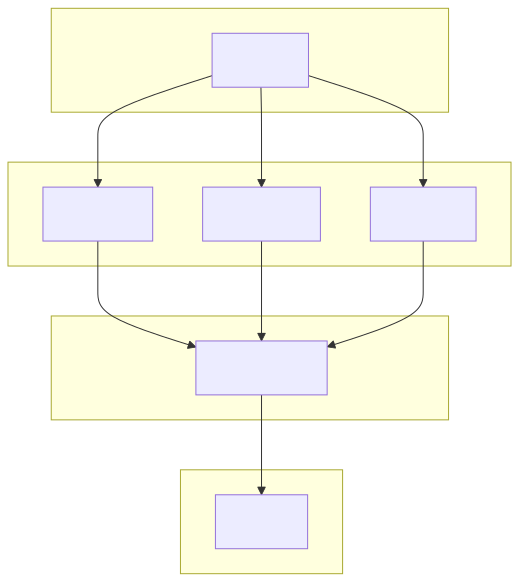

In [7]:
const complexDagWorkflow = {
  id: "complex-dag",
  tasks: [
    { id: "fetch", tool_name: "fetch", dependencies: [] },
    { id: "extract", tool_name: "extract", dependencies: ["fetch"] },
    { id: "validate", tool_name: "validate", dependencies: ["fetch"] },
    { id: "enrich", tool_name: "enrich", dependencies: ["fetch"] },
    { id: "transform", tool_name: "transform", dependencies: ["extract", "validate", "enrich"] },
    { id: "save", tool_name: "save", dependencies: ["transform"] },
  ],
};

const complexLayers = [
  [complexDagWorkflow.tasks[0]], // Layer 0: fetch
  [complexDagWorkflow.tasks[1], complexDagWorkflow.tasks[2], complexDagWorkflow.tasks[3]], // Layer 1: parallel
  [complexDagWorkflow.tasks[4]], // Layer 2: transform (fan-in)
  [complexDagWorkflow.tasks[5]], // Layer 3: save
];

console.log("📊 4 layers: fetch → parallel processing → transform → save\n");

// Display visual diagram
await displayLayers(complexLayers);

## Visualize Complex Multi-Layer DAG

Fan-out → Parallel Processing → Fan-in pattern:

## Parallel DAG Execution

Now with tasks that can run in parallel:

```
    ┌─ taskA ─┐
start│         │→ combine
    └─ taskB ─┘
```

In [8]:
const parallelDag = {
  tasks: {
    taskA: {
      tool: "sandbox",
      params: { code: "return { source: 'A', value: Math.random() * 100 }" },
      dependencies: [],
    },
    taskB: {
      tool: "sandbox",
      params: { code: "return { source: 'B', value: Math.random() * 100 }" },
      dependencies: [],
    },
    combine: {
      tool: "sandbox",
      params: {
        code:
          "return { total: context.A.value + context.B.value, sources: [context.A.source, context.B.source] }",
      },
      dependencies: ["taskA", "taskB"],
    },
  },
};

console.log("🔀 Parallel DAG:");
console.log("   taskA (no deps)");
console.log("   taskB (no deps)");
console.log("   combine (depends on A and B)");

🔀 Parallel DAG:
   taskA (no deps)
   taskB (no deps)
   combine (depends on A and B)


In [9]:
// Execute A and B in parallel
console.log("\n⚡ Executing taskA and taskB in parallel...");

const [resultA, resultB] = await Promise.all([
  sandbox.execute(parallelDag.tasks.taskA.params.code),
  sandbox.execute(parallelDag.tasks.taskB.params.code),
]);

console.log("   taskA:", resultA.result);
console.log("   taskB:", resultB.result);

// Combine results
console.log("\n🔗 Combining results...");
const combined = await sandbox.execute(
  parallelDag.tasks.combine.params.code,
  { A: resultA.result, B: resultB.result },
);

console.log("   Combined:", combined.result);
console.log("\n✅ Parallel workflow complete!");


⚡ Executing taskA and taskB in parallel...
INFO Sandbox execution succeeded
INFO Sandbox execution succeeded
   taskA: { source: "A", value: 35.72304563776109 }
   taskB: { source: "B", value: 46.71121990417839 }

🔗 Combining results...
   Combined: undefined

✅ Parallel workflow complete!


## Complex DAG with Multiple Layers

```
       ┌─ extract ─┐
fetch ─┼─ validate ─┼─ transform ─ save
       └─ enrich ──┘
```

In [10]:
const complexDag = {
  tasks: {
    fetch: {
      code: "return { users: [{id: 1, name: 'Alice'}, {id: 2, name: 'Bob'}] }",
      deps: [],
    },
    extract: {
      code: "return context.users.map(u => u.name)",
      deps: ["fetch"],
    },
    validate: {
      code:
        "return { valid: context.users.every(u => u.id && u.name), count: context.users.length }",
      deps: ["fetch"],
    },
    enrich: {
      code: "return context.users.map(u => ({ ...u, createdAt: new Date().toISOString() }))",
      deps: ["fetch"],
    },
    transform: {
      code:
        "return { names: context.extract, isValid: context.validate.valid, enriched: context.enrich }",
      deps: ["extract", "validate", "enrich"],
    },
    save: {
      code:
        "return { saved: true, summary: `Saved ${context.names.length} users, valid: ${context.isValid}` }",
      deps: ["transform"],
    },
  },
};

// Execute layer by layer
const results: Record<string, unknown> = {};

console.log("🏗️  Executing complex DAG...\n");

// Layer 1: fetch
console.log("Layer 1: fetch");
results.fetch = (await sandbox.execute(complexDag.tasks.fetch.code)).result;
console.log("   ✓ fetch complete");

// Layer 2: extract, validate, enrich (parallel)
console.log("\nLayer 2: extract, validate, enrich (parallel)");
const [extract, validate, enrich] = await Promise.all([
  sandbox.execute(complexDag.tasks.extract.code, results.fetch),
  sandbox.execute(complexDag.tasks.validate.code, results.fetch),
  sandbox.execute(complexDag.tasks.enrich.code, results.fetch),
]);
results.extract = extract.result;
results.validate = validate.result;
results.enrich = enrich.result;
console.log("   ✓ extract, validate, enrich complete");

// Layer 3: transform
console.log("\nLayer 3: transform");
results.transform = (await sandbox.execute(
  complexDag.tasks.transform.code,
  { extract: results.extract, validate: results.validate, enrich: results.enrich },
)).result;
console.log("   ✓ transform complete");

// Layer 4: save
console.log("\nLayer 4: save");
results.save = (await sandbox.execute(
  complexDag.tasks.save.code,
  results.transform,
)).result;
console.log("   ✓ save complete");

console.log("\n📊 Final result:");
console.log(JSON.stringify(results.save, null, 2));

🏗️  Executing complex DAG...

Layer 1: fetch
INFO Sandbox execution succeeded
   ✓ fetch complete

Layer 2: extract, validate, enrich (parallel)
   ✓ extract, validate, enrich complete

Layer 3: transform
   ✓ transform complete

Layer 4: save
   ✓ save complete

📊 Final result:
undefined


## Summary

**DAG Workflows enable:**

- ✅ Sequential task execution with dependencies
- ✅ Parallel execution of independent tasks
- ✅ Context passing between tasks
- ✅ Complex multi-layer workflows

**Use cases:**

- ETL pipelines
- Data processing workflows
- Multi-step AI agent tasks
- Orchestrated tool execution